In [1]:
import numpy as np
import pcs as pcs
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import least_squares
from nepc import nepc
from nepc.methods.mp import mp as mp
from nepc.methods.thomson import thomson as thomson
from nepc.methods.wunderlich import gryzinski as gryzinski
from nepc.util.constants import N2_DIATOMIC_CONSTANTS
from nepc.util.constants import MU_NITROGEN_KG
from nepc.util.constants import WAVENUMBER_PER_EV as WAVENUMBER_PER_EV
from numpy import exp

# Plot psi_v, v=10

In [2]:
N2_DIATOMIC_CONSTANTS.keys()

dict_keys(['N2(X1Sigmag+)', 'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2(W3Deltau)', 'N2(Bp3Sigmau-)', 'N2(ap1Sigmau-)', 'N2(a1Pig)', 'N2(w1Deltau)', 'N2(C3Piu)', 'N2+(X2Sigmag+)', 'N2+(A2Piu)', 'N2+(B2Sigmau+)', 'N2+(C2Sigmau+)'])

# Compute Overlap Matrix and Check for Identity

In [3]:
overlap_X = thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                          reduced_mass=MU_NITROGEN_KG,
                          k=15,
                          delta_r=.5,
                          dbug=False)

In [4]:
thomson.rmse_diagonal_elements(np.asarray(overlap_X))

3.161428664381842e-07

In [5]:
thomson.incremental_rmse_diagonal_elements(np.asarray(overlap_X))

i: 1; rmse: 1.176836406102666e-14
i: 2; rmse: 7.395002138012975e-14
i: 3; rmse: 7.568746825928083e-14
i: 4; rmse: 6.917836816315628e-13
i: 5; rmse: 1.8139926137618884e-12
i: 6; rmse: 5.928549341399212e-11
i: 7; rmse: 1.19007640217334e-09
i: 8; rmse: 3.498371376887217e-09
i: 9; rmse: 5.628449990979163e-09
i: 10; rmse: 1.5065349718683008e-07
i: 11; rmse: 3.161428664381842e-07


In [6]:
thomson.rmse_off_diagonal_elements(np.asarray(overlap_X))

6.371907694890456e-09

In [7]:
thomson.incremental_rmse_off_diagonal_elements(np.asarray(overlap_X))

i: 2; rmse: 2.035766006449552e-25
i: 3; rmse: 7.383796949441263e-24
i: 4; rmse: 1.4220724653275325e-21
i: 5; rmse: 5.661805700118586e-20
i: 6; rmse: 1.3281017281782437e-17
i: 7; rmse: 1.2702339582927547e-15
i: 8; rmse: 3.710459103402972e-15
i: 9; rmse: 2.2655393863261183e-13
i: 10; rmse: 5.4361129387637255e-11
i: 11; rmse: 6.371907694890456e-09


# Closure relationship for FCF
If the FCF sum over vpp for a given vp are greater than 0.99, that's were we'll stop including cross sections

In [8]:
p_list = ['N2(X1Sigmag+)',  'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2(W3Deltau)', 'N2(Bp3Sigmau-)', 'N2(ap1Sigmau-)', 'N2(a1Pig)', 'N2(w1Deltau)', 'N2(C3Piu)']
pp_list = ['N2+(X2Sigmag+)', 'N2+(A2Piu)', 'N2+(B2Sigmau+)', 'N2+(C2Sigmau+)']
vp_list = [0,1,2,3,4,5,6,7,8]
vpp_list = [0,1,2,3,4,5,6,7,8,9]

In [9]:
fcf = []
"""fcf[p][pp][vp][vpp]"""
for p in np.arange(len(p_list)):
    fcf.append([])
    for pp in np.arange(len(pp_list)):
        fcf[p].append(thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS[p_list[p]],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS[pp_list[pp]],
                          reduced_mass=MU_NITROGEN_KG,
                          k=15,
                          delta_r=.5,
                          dbug=False))

In [10]:
max_vpp = [1,5,1]

In [11]:
fcf_closure_matrix = []
"fcf_closure_matrix[p][pp][vp] provides the vpp state # needed to reach >0.99 closure"
"Example: fcf_closure_matrix[0][1][2]=4 (X1Sigmag+ -> A2Piu, vp=2, vpp(0+1+2+3+4))"
for p in np.arange(9):
    fcf_closure_matrix.append([])
    for pp in np.arange(4):
        fcf_closure_matrix[p].append([])
        
"X1Sigmag+"
fcf_closure_matrix[0].insert(0, [1,3,4,5,6,7,9,9,np.nan])
fcf_closure_matrix[0].insert(1, [5,7,9,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[0].insert(2, [1,2,4,5,6,6,7,8,9])
fcf_closure_matrix[0].insert(3, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])

"A3Piu+"
fcf_closure_matrix[1].insert(0, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[1].insert(1, [5,6,8,9,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[1].insert(2, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[1].insert(3, [3,5,7,9,np.nan,np.nan,np.nan,np.nan,np.nan])

"B3Pig"
fcf_closure_matrix[2].insert(0, [5,6,8,9,9,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[2].insert(1, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[2].insert(2, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[2].insert(3, [7,9,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])

"W3Deltau"
fcf_closure_matrix[3].insert(0, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[3].insert(1, [4,6,8,9,9,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[3].insert(2, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[3].insert(3, [2,5,6,9,9,np.nan,np.nan,np.nan,np.nan])

"Bp3Sigmau-"
fcf_closure_matrix[4].insert(0, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[4].insert(1, [4,6,8,9,9,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[4].insert(2, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[4].insert(3, [2,5,6,9,9,np.nan,np.nan,np.nan,np.nan])

"ap1Sigmau-"
fcf_closure_matrix[5].insert(0, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[5].insert(1, [4,6,8,9,9,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[5].insert(2, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[5].insert(3, [2,5,6,9,9,np.nan,np.nan,np.nan,np.nan])

"a1Pig"
fcf_closure_matrix[6].insert(0, [5,7,9,9,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[6].insert(1, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[6].insert(2, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[6].insert(3, [6,9,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])

"w1Deltau"
fcf_closure_matrix[7].insert(0, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[7].insert(1, [4,6,7,8,9,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[7].insert(2, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[7].insert(3, [2,5,6,9,9,np.nan,np.nan,np.nan,np.nan])

"C3Piu"
fcf_closure_matrix[8].insert(0, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[8].insert(1, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[8].insert(2, [5,7,9,9,np.nan,np.nan,np.nan,np.nan,np.nan])
fcf_closure_matrix[8].insert(3, [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])

# Total cross section data from literature

In [12]:
INCIDENT_ENERGY = [16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 110.0, 120.0, 140.0, 160.0, 180.0, 200.0, 225.0, 250.0, 275.0, 300.0, 350.0, 400.0, 450.0, 500.0, 550.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0]
ITIKAWA = np.asarray([0.0211, 0.0466, 0.0713, 0.0985, 0.129, 0.164, 0.199, 0.23, 0.27, 0.308, 0.344, 0.38, 0.418, 0.455, 0.492, 0.528, 0.565, 0.603, 0.64, 0.929, 1.16, 1.37, 1.52, 1.6, 1.66, 1.72, 1.74, 1.78, 1.8, 1.81, 1.82, 1.83, 1.85, 1.85, 1.83, 1.81, 1.78, 1.72, 1.67, 1.61, 1.55, 1.48, 1.41, 1.37, 1.28, 1.2, 1.11, 1.05, 0.998, 0.943, 0.88, 0.844, 0.796, 0.765, 0.738, 0.719, 0.698, 0.676])

In [13]:
INCIDENT_ENERGY[33]

100.0

# Function for computing the cross sections for N2 X1 to N2+ X2, A2, B2. It will be used to find the coefficients of the universal function

In [14]:
def compute_totalcs(Coefficients):
    A, B, C = Coefficients
    pcs_XX = []
    pcs_XA = []
    pcs_XB = []
    total_pcs = np.zeros(58)   
    
    for vpp in np.arange(2):
        pcs_data = pcs.pcs(p_state='N2(X1Sigmag+)', pp_state='N2+(X2Sigmag+)', 
                            vp=0, vpp=vpp, fcf=fcf[0][0][0][vpp],
                            a=A, b=B, c=C)[1]
        pcs_XX.append(pcs_data)
        
    for vpp in np.arange(6):
        pcs_data = pcs.pcs(p_state='N2(X1Sigmag+)', pp_state='N2+(A2Piu)', 
                            vp=0, vpp=vpp, fcf=fcf[0][1][0][vpp],
                            a=A, b=B, c=C)[1]
        pcs_XA.append(pcs_data)
        
    for vpp in np.arange(2):
        pcs_data = pcs.pcs(p_state='N2(X1Sigmag+)', pp_state='N2+(B2Sigmau+)', 
                            vp=0, vpp=vpp, fcf=fcf[0][2][0][vpp],
                            a=A, b=B, c=C)[1]
        pcs_XB.append(pcs_data)

    pcs_XX = pcs_XX[0] + pcs_XX[1]
    pcs_XA = pcs_XA[0] + pcs_XA[1] + pcs_XA[2] + pcs_XA[3] + pcs_XA[4] + pcs_XA[5]
    pcs_XB = pcs_XB[0] + pcs_XB[1]
    
    total_pcs = pcs_XX + pcs_XA + pcs_XB
    
    return total_pcs, pcs_XX, pcs_XA, pcs_XB

# Initial guess for universal function parameters: a=2.6, b=9.2, c=2.4

In [15]:
def ssr_total(Coefficients):
    """computes the SSR for the total cross section compared to Itikawa's. 
    Then using minimize to find the coefficients that produce the smallest SSR"""
    
    total_pcs = compute_totalcs(Coefficients)[0]
    
    diff_sq = (ITIKAWA - (total_pcs*1.0E20))**2
    sum_diff = np.sum(diff_sq)
    
    return sum_diff

In [16]:
print(ssr_total([1.91, 10, 2]))
x0 = np.asarray([1.91, 10, 2])
res =  minimize(ssr_total, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp':True})
print(res)

6.71083629453519
Optimization terminated successfully.
         Current function value: 0.047834
         Iterations: 145
         Function evaluations: 266
 final_simplex: (array([[ 2.56261422, 11.74626326,  1.00890865],
       [ 2.56261422, 11.74626325,  1.00890865],
       [ 2.56261422, 11.74626326,  1.00890865],
       [ 2.56261422, 11.74626326,  1.00890865]]), array([0.04783391, 0.04783391, 0.04783391, 0.04783391]))
           fun: 0.04783390527304007
       message: 'Optimization terminated successfully.'
          nfev: 266
           nit: 145
        status: 0
       success: True
             x: array([ 2.56261422, 11.74626326,  1.00890865])


### The coefficients are good to 1.0E-7 and fluxuate a bit after that for different initial values

# Computing the partial cross sections

In [17]:
all_pcs = compute_totalcs([2.56261423, 1.00890863, 11.74626336])
total_pcs = all_pcs[0]
pcsXX = all_pcs[1]
pcsXA = all_pcs[2]
pcsXB = all_pcs[3]

print('XX: {}; XA: {}; XB: {}'.format(pcsXX[33]*1.0E22, pcsXA[33]*1.0E22, pcsXB[33]*1.0E22))

XX: 54.91349148767361; XA: 92.07603572138949; XB: 37.69418210303359


In [18]:
all_pcs = compute_totalcs([1.91, 10, 2])
total_pcs = all_pcs[0]
pcsXX = all_pcs[1]
pcsXA = all_pcs[2]
pcsXB = all_pcs[3]

print('XX: {}; XA: {}; XB: {}'.format(pcsXX[33]*1.0E22, pcsXA[33]*1.0E22, pcsXB[33]*1.0E22))

XX: 39.94720707515701; XA: 66.59062724159247; XB: 27.060970955837043


## Matrix loop for computing all the partial cross sections allowed by the closure relationship

In [19]:
partial_cross_sections = []
"""partial_cross_sections[p][pp][vp][vpp][energy/cross section]"""
for p in np.arange(len(p_list)):
    partial_cross_sections.append([])
    for pp in np.arange(len(pp_list)):
        partial_cross_sections[p].append([])
        for vp in np.arange(9):
            partial_cross_sections[p][pp].append([])
            if type(fcf_closure_matrix[p][pp][vp])==int:
                for vpp in np.arange(fcf_closure_matrix[p][pp][vp]+1):
                    partial_cross_sections[p][pp][vp].append(pcs.pcs(p_state=p_list[p], pp_state=pp_list[pp], 
                                                                vp=vp, vpp=vpp, fcf=fcf[p][pp][vp][vpp],
                                                                a=2.56261423, b=1.00890863, c=11.74626336))

# Sorting Partial Cross Sections

# Figures and Tables

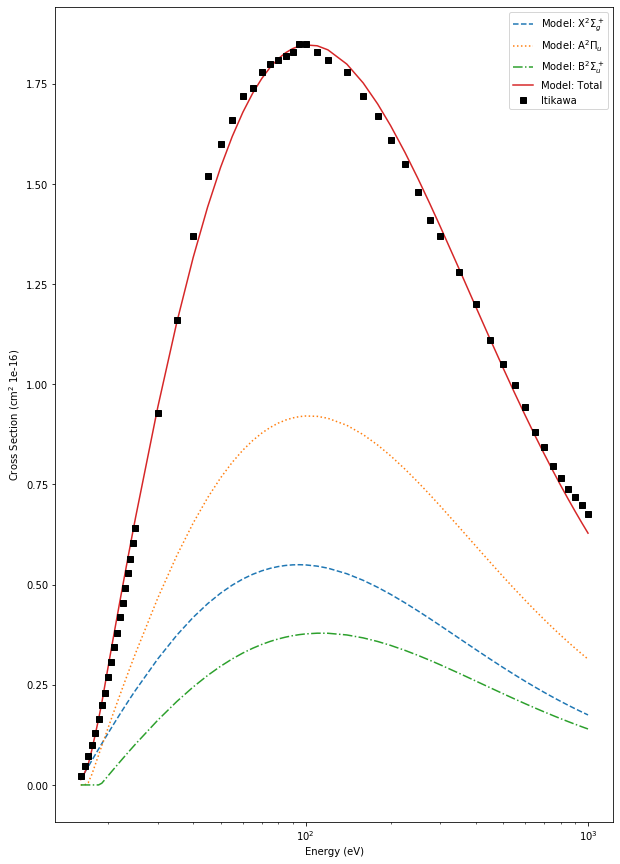

In [20]:
fig, ax = plt.subplots(1, figsize=(10,15))
ax.plot(INCIDENT_ENERGY, (partial_cross_sections[0][0][0][0][1]+partial_cross_sections[0][0][0][1][1])*1.0E20, '--', label='Model: X$^2\Sigma_g^+$')
ax.plot(INCIDENT_ENERGY, (partial_cross_sections[0][1][0][0][1]+partial_cross_sections[0][1][0][1][1]+partial_cross_sections[0][1][0][2][1]+partial_cross_sections[0][1][0][3][1]+partial_cross_sections[0][1][0][4][1]+partial_cross_sections[0][1][0][5][1])*1.0E20, ':', label='Model: A$^2\Pi_u$')
ax.plot(INCIDENT_ENERGY, (partial_cross_sections[0][2][0][0][1]+partial_cross_sections[0][2][0][1][1])*1.0E20, '-.', label='Model: B$^2\Sigma_u^+$')
ax.plot(INCIDENT_ENERGY, (partial_cross_sections[0][0][0][0][1]+partial_cross_sections[0][0][0][1][1]+partial_cross_sections[0][1][0][0][1]+partial_cross_sections[0][1][0][1][1]+partial_cross_sections[0][1][0][2][1]+partial_cross_sections[0][1][0][3][1]+partial_cross_sections[0][1][0][4][1]+partial_cross_sections[0][1][0][5][1]+partial_cross_sections[0][2][0][0][1]+partial_cross_sections[0][2][0][1][1])*1.0E20, label='Model: Total')
ax.plot(INCIDENT_ENERGY, ITIKAWA, 'ks', label='Itikawa')
ax.set_xscale('log')
ax.set_ylabel('Cross Section (cm$^2$ 1e-16)')
ax.set_xlabel('Energy (eV)')
#ax.set_title(r'Comparision of Morse-Pekeris Thomson model for N$_2$ X$^1\Sigma_g^+$ v$^p$=0 to N$_2^+$ ionization cross sections to experimental data')
ax.legend()
plt.show()

In [21]:
tmp_XX = (partial_cross_sections[0][0][0][0][1]+partial_cross_sections[0][0][0][1][1])*1.0E20
tmp_XA = (partial_cross_sections[0][1][0][0][1]+partial_cross_sections[0][1][0][1][1]+partial_cross_sections[0][1][0][2][1]+partial_cross_sections[0][1][0][3][1]+partial_cross_sections[0][1][0][4][1]+partial_cross_sections[0][1][0][5][1])*1.0E20
tmp_XB = (partial_cross_sections[0][2][0][0][1]+partial_cross_sections[0][2][0][1][1])*1.0E20
tmp_total = tmp_XX+tmp_XA+tmp_XB

print(r'E(eV) & Itikawa (cm e-16) & Model Total & X$^2\Sigma_g^+$ & A$^2\Pi_u$ & B$^2\Sigma_u^+$ \\')
print('\hline')
for i in np.arange(58):
    print('{0:.1f} & {1:.2f} & {2:.2f} & {3:.2f} & {4:.2f} & {5:.2f}  \\\\' .format(INCIDENT_ENERGY[i], ITIKAWA[i], tmp_total[i], tmp_XX[i], tmp_XA[i], tmp_XB[i]))

E(eV) & Itikawa (cm e-16) & Model Total & X$^2\Sigma_g^+$ & A$^2\Pi_u$ & B$^2\Sigma_u^+$ \\
\hline
16.0 & 0.02 & 0.01 & 0.01 & 0.00 & 0.00  \\
16.5 & 0.05 & 0.03 & 0.03 & 0.00 & 0.00  \\
17.0 & 0.07 & 0.05 & 0.05 & 0.01 & 0.00  \\
17.5 & 0.10 & 0.09 & 0.06 & 0.03 & 0.00  \\
18.0 & 0.13 & 0.13 & 0.08 & 0.05 & 0.00  \\
18.5 & 0.16 & 0.16 & 0.09 & 0.07 & 0.00  \\
19.0 & 0.20 & 0.21 & 0.10 & 0.10 & 0.00  \\
19.5 & 0.23 & 0.25 & 0.12 & 0.12 & 0.01  \\
20.0 & 0.27 & 0.29 & 0.13 & 0.14 & 0.02  \\
20.5 & 0.31 & 0.34 & 0.14 & 0.16 & 0.03  \\
21.0 & 0.34 & 0.38 & 0.15 & 0.18 & 0.04  \\
21.5 & 0.38 & 0.42 & 0.16 & 0.20 & 0.05  \\
22.0 & 0.42 & 0.46 & 0.18 & 0.22 & 0.06  \\
22.5 & 0.46 & 0.49 & 0.19 & 0.24 & 0.07  \\
23.0 & 0.49 & 0.53 & 0.20 & 0.26 & 0.07  \\
23.5 & 0.53 & 0.57 & 0.21 & 0.28 & 0.08  \\
24.0 & 0.56 & 0.60 & 0.22 & 0.30 & 0.09  \\
24.5 & 0.60 & 0.63 & 0.23 & 0.31 & 0.09  \\
25.0 & 0.64 & 0.67 & 0.24 & 0.33 & 0.10  \\
30.0 & 0.93 & 0.94 & 0.31 & 0.47 & 0.16  \\
35.0 & 1.16 & 1.15 & 

## Computing the percent error

In [22]:
def percent_error(theoretical, experimental):
    return abs(experimental - theoretical)/abs(theoretical)

percenterror = []
tot_percenterror = 0
for i in np.arange(58):
    percenterror.append(percent_error(ITIKAWA[i], tmp_total[i]))
    tot_percenterror += percent_error(ITIKAWA[i], tmp_total[i])
average_percent_error = tot_percenterror/58
print(average_percent_error)
print(percenterror)

0.050404374092132644
[0.36556086328007864, 0.36253452870153813, 0.2866128957467907, 0.12480617757471818, 0.027777501518245252, 0.0013296334779709074, 0.031010356558600696, 0.08905834062346633, 0.0905749850913682, 0.09429744981313537, 0.09972241450191721, 0.10076579041001568, 0.09342922778018879, 0.0871198567535611, 0.07946082788099978, 0.07284491965558605, 0.06333223834761129, 0.051568061864315125, 0.04130898787589859, 0.015622785274777777, 0.005214724972864629, 0.039389797503193866, 0.05124801587072748, 0.03702535063558998, 0.025190722593486755, 0.02388627845097852, 0.007838407458923037, 0.009484114767763386, 0.0048892372644988085, 0.0012065566855930234, 0.004025118979719658, 0.004169798612926256, 0.0032902371123688353, 0.0017096793940720601, 0.008033088787836588, 0.013572314062238218, 0.010662034472456833, 0.01854257752378236, 0.01771738618227398, 0.022062980414653658, 0.018276067214465112, 0.022542820812022576, 0.02946901551985043, 0.01696931408610693, 0.0056568614534390285, 0.00469

## Branching ratios for N2+(X2), N2+(A2), N2+(B2) 

### Computing by dividing the cross sections of each individual state by the total cross section (all at 100 eV) 

In [23]:
print('N2+(X2): {0:.2f}\nN2+(A2): {1:.2f}\nN2+(B2): {2:.2f}'.format(0.55/1.85, 0.92/1.85, 0.38/1.85))

N2+(X2): 0.30
N2+(A2): 0.50
N2+(B2): 0.21


In [24]:
print(partial_cross_sections[0][0][0][0][1][33])
print(partial_cross_sections[0][1][0][0][1][33])
print(partial_cross_sections[0][2][0][0][1][33])

5.031954146000916e-21
2.4165444452093803e-21
3.3248910983670726e-21


# Computing cross sections using the Gryzinski theory

# Comparisons and fits based on Shemansky Model
### Each p' to p'' state gets its own universal function fit based on Shemansky's model

In [28]:
import csv
SHEMANSKY = []
with open('shemansky.csv', newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    for row in data:
        SHEMANSKY.append(row)

for i in np.arange(55, 67):
    SHEMANSKY[i].insert(1, 0.0)        

INCIDENT_ENERGY_SHE = []
SHEMANSKY_OBS = []
SHEMANSKY_MODEL = []
SHEMANSKY_XX = []
SHEMANSKY_XA =[]
SHEMANSKY_XB = []

for i in np.arange(67):
    INCIDENT_ENERGY_SHE.append(SHEMANSKY[i][0])
    SHEMANSKY_OBS.append(SHEMANSKY[i][1])
    SHEMANSKY_MODEL.append(SHEMANSKY[i][2])
    SHEMANSKY_XX.append(SHEMANSKY[i][3])
    SHEMANSKY_XA.append(SHEMANSKY[i][4])
    SHEMANSKY_XB.append(SHEMANSKY[i][5])
INCIDENT_ENERGY_SHE = np.asarray(INCIDENT_ENERGY_SHE)
SHEMANSKY_OBS = np.asarray(SHEMANSKY_OBS)/100
SHEMANSKY_MODEL = np.asarray(SHEMANSKY_MODEL)/100
SHEMANSKY_XX = np.asarray(SHEMANSKY_XX)/100
SHEMANSKY_XA = np.asarray(SHEMANSKY_XA)/100
SHEMANSKY_XB = np.asarray(SHEMANSKY_XB)/100

## N2 X1Sigmag+ to N2+ X2Sigmag+

In [29]:
def find_ufc_XX(Coefficients):
    """computes the SSR for the total cross section compared to Itikawa's. 
    Then using minimize to find the coefficients that produce the smallest SSR"""
    N, B, C = Coefficients
    ee_pcs = []
    for pp in np.arange(1):
        for vp in np.arange(1):
            for vpp in np.arange(2):
                pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
                sigmas = []
                for i in range(len(pcs_data)):
                    sigmas.append(pcs_data[i][1])
                ee_pcs.append(sigmas)
    
    ee_pcs[0].pop(0)
    ee_pcs[0].pop(16)
    ee_pcs[0].pop(16)
    ee_pcs[1].pop(0)
    ee_pcs[1].pop(16)
    ee_pcs[1].pop(16)
    ee_pcs = np.asarray(ee_pcs)
    total_pcs = np.zeros(55)
    for i in ee_pcs:
        total_pcs += i
    
    SHEMANSKY_XX_55 = []
    INCIDENT_ENERGY_SHE_55 = []
    for i in np.arange(55):
        SHEMANSKY_XX_55.append(SHEMANSKY_XX[i])
        INCIDENT_ENERGY_SHE_55.append(INCIDENT_ENERGY_SHE[i])
    
    SHEMANSKY_XX_55 = np.asarray(SHEMANSKY_XX_55)
    
    diff_sq = (SHEMANSKY_XX_55 - (total_pcs*1.0E20))**2
    sum_diff = np.sum(diff_sq)
    
    return sum_diff

In [30]:
ee_pcs_XX = []
N, B, C = [4.48610974, 16.53230571,  0.67914942]
for pp in np.arange(1):
    for vp in np.arange(1):
        for vpp in np.arange(2):
            pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
            sigmas = []
            for i in range(len(pcs_data)):
                sigmas.append(pcs_data[i][1])
            ee_pcs_XX.append(sigmas)
            
ee_pcs_XX[0].pop(0)
ee_pcs_XX[0].pop(16)
ee_pcs_XX[0].pop(16)
ee_pcs_XX[1].pop(0)
ee_pcs_XX[1].pop(16)
ee_pcs_XX[1].pop(16)
ee_pcs_XX = np.asarray(ee_pcs_XX)
total_pcs_XX = np.zeros(55)
for i in ee_pcs_XX:
    total_pcs_XX += i

SHEMANSKY_XX_55 = []
INCIDENT_ENERGY_SHE_55 = []
for i in np.arange(55):
    SHEMANSKY_XX_55.append(SHEMANSKY_XX[i])
    INCIDENT_ENERGY_SHE_55.append(INCIDENT_ENERGY_SHE[i])
    
SHEMANSKY_XX_55 = np.asarray(SHEMANSKY_XX_55)

INCIDENT_ENERGY_55 = []
for i in INCIDENT_ENERGY:
    INCIDENT_ENERGY_55.append(i)
INCIDENT_ENERGY_55.pop(0)
INCIDENT_ENERGY_55.pop(16)
INCIDENT_ENERGY_55.pop(16)

diff_sq = (SHEMANSKY_XX_55 - (total_pcs_XX*1.0E20))**2
np.sum(diff_sq)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [31]:
find_ufc_XX([2.56261423, 11.74626331,  1.00890865])
x0 = np.asarray([2.56261423, 11.74626331,  1.00890865])
res =  minimize(find_ufc_XX, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp':True})
print(res)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
fig3, ax3 = plt.subplots(1)
ax3.plot(INCIDENT_ENERGY_55, (total_pcs_XX)*1.0E20, label='thomson XX')
ax3.plot(INCIDENT_ENERGY_SHE_55, SHEMANSKY_XX_55, label='she_xx')
ax3.set_xscale('log')
ax3.set_ylabel('cm$^2 (1e-16)$')
ax3.set_xlabel('eV')
ax3.legend()
plt.show()

## N2 X1Sigmag+ to N2+ A2Piu

In [ ]:
def find_ufc_XA(Coefficients):
    """computes the SSR for the total cross section compared to Itikawa's. 
    Then using minimize to find the coefficients that produce the smallest SSR"""
    N, B, C = Coefficients
    ee_pcs = []
    for pp in np.arange(1,2):
        for vp in np.arange(1):
            for vpp in np.arange(6):
                pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
                sigmas = []
                for i in range(len(pcs_data)):
                    sigmas.append(pcs_data[i][1])
                ee_pcs.append(sigmas)
    for i in np.arange(6):
        ee_pcs[i].pop(0)
        ee_pcs[i].pop(16)
        ee_pcs[i].pop(16)
        ee_pcs = np.asarray(ee_pcs)
    total_pcs = np.zeros(55)
    for i in ee_pcs:
        total_pcs += i
    
    SHEMANSKY_XA_55 = []
    INCIDENT_ENERGY_SHE_55 = []
    for i in np.arange(55):
        SHEMANSKY_XA_55.append(SHEMANSKY_XA[i])
        INCIDENT_ENERGY_SHE_55.append(INCIDENT_ENERGY_SHE[i])
    
    SHEMANSKY_XA_55 = np.asarray(SHEMANSKY_XA_55)
    
    diff_sq = (SHEMANSKY_XA_55 - (total_pcs*1.0E20))**2
    sum_diff = np.sum(diff_sq)
    
    return sum_diff

In [ ]:
ee_pcs_XA = []
N, B, C = [1.91631027, 4.19096724, 4.19096734]
for pp in np.arange(1,2):
    for vp in np.arange(1):
        for vpp in np.arange(6):
            pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
            sigmas = []
            for i in range(len(pcs_data)):
                sigmas.append(pcs_data[i][1])
            ee_pcs_XA.append(sigmas)

for i in np.arange(6):
    ee_pcs_XA[i].pop(0)
    ee_pcs_XA[i].pop(16)
    ee_pcs_XA[i].pop(16)

ee_pcs_XA = np.asarray(ee_pcs_XA)
total_pcs_XA = np.zeros(55)
for i in ee_pcs_XA:
    total_pcs_XA += i

SHEMANSKY_XA_55 = []
INCIDENT_ENERGY_SHE_55 = []
for i in np.arange(55):
    SHEMANSKY_XA_55.append(SHEMANSKY_XA[i])
    INCIDENT_ENERGY_SHE_55.append(INCIDENT_ENERGY_SHE[i])
    
SHEMANSKY_XA_55 = np.asarray(SHEMANSKY_XA_55)

INCIDENT_ENERGY_55 = []
for i in INCIDENT_ENERGY:
    INCIDENT_ENERGY_55.append(i)
INCIDENT_ENERGY_55.pop(0)
INCIDENT_ENERGY_55.pop(16)
INCIDENT_ENERGY_55.pop(16)

diff_sq = (SHEMANSKY_XA_55 - (total_pcs_XA*1.0E20))**2
np.sum(diff_sq)

In [ ]:
find_ufc_XA([2.56261423, 11.74626331,  1.00890865])
x0 = np.asarray([2.56261423, 11.74626331,  1.00890865])
res =  minimize(find_ufc_XA, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp':True})
print(res)

In [ ]:
fig4, ax4 = plt.subplots(1)
ax4.plot(INCIDENT_ENERGY_55, (total_pcs_XA)*1.0E20, label='thomson XA')
ax4.plot(INCIDENT_ENERGY_SHE_55, SHEMANSKY_XA_55, label='she_xa')
ax4.set_xscale('log')
ax4.set_ylabel('cm$^2 (1e-16)$')
ax4.set_xlabel('eV')
ax4.legend()
plt.show()

## N2 X1Sigmag+ to N2+ B2Sigmau+

In [ ]:
def find_ufc_XB(Coefficients):
    """computes the SSR for the total cross section compared to Itikawa's. 
    Then using minimize to find the coefficients that produce the smallest SSR"""
    N, B, C = Coefficients
    ee_pcs = []
    for pp in np.arange(2,3):
        for vp in np.arange(1):
            for vpp in np.arange(2):
                pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
                sigmas = []
                for i in range(len(pcs_data)):
                    sigmas.append(pcs_data[i][1])
                ee_pcs.append(sigmas)
    for i in np.arange(2):
        ee_pcs[i].pop(0)
        ee_pcs[i].pop(16)
        ee_pcs[i].pop(16)
        ee_pcs = np.asarray(ee_pcs)
    total_pcs = np.zeros(55)
    for i in ee_pcs:
        total_pcs += i
    
    SHEMANSKY_XB_55 = []
    INCIDENT_ENERGY_SHE_55 = []
    for i in np.arange(55):
        SHEMANSKY_XB_55.append(SHEMANSKY_XB[i])
        INCIDENT_ENERGY_SHE_55.append(INCIDENT_ENERGY_SHE[i])
    
    SHEMANSKY_XB_55 = np.asarray(SHEMANSKY_XB_55)
    
    diff_sq = (SHEMANSKY_XB_55 - (total_pcs*1.0E20))**2
    sum_diff = np.sum(diff_sq)
    
    return sum_diff

In [ ]:
ee_pcs_XB = []
N, B, C = [1.36055036, 8.63427827, 1.27025972]
for pp in np.arange(2,3):
    for vp in np.arange(1):
        for vpp in np.arange(2):
            pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
            sigmas = []
            for i in range(len(pcs_data)):
                sigmas.append(pcs_data[i][1])
            ee_pcs_XB.append(sigmas)

for i in np.arange(2):
    ee_pcs_XB[i].pop(0)
    ee_pcs_XB[i].pop(16)
    ee_pcs_XB[i].pop(16)

ee_pcs_XB = np.asarray(ee_pcs_XB)
total_pcs_XB = np.zeros(55)
for i in ee_pcs_XB:
    total_pcs_XB += i

SHEMANSKY_XB_55 = []
INCIDENT_ENERGY_SHE_55 = []
for i in np.arange(55):
    SHEMANSKY_XB_55.append(SHEMANSKY_XB[i])
    INCIDENT_ENERGY_SHE_55.append(INCIDENT_ENERGY_SHE[i])
    
SHEMANSKY_XB_55 = np.asarray(SHEMANSKY_XB_55)

INCIDENT_ENERGY_55 = []
for i in INCIDENT_ENERGY:
    INCIDENT_ENERGY_55.append(i)
INCIDENT_ENERGY_55.pop(0)
INCIDENT_ENERGY_55.pop(16)
INCIDENT_ENERGY_55.pop(16)

diff_sq = (SHEMANSKY_XB_55 - (total_pcs_XB*1.0E20))**2
np.sum(diff_sq)

In [ ]:
find_ufc_XB([2.56261423, 11.74626331,  1.00890865])
x0 = np.asarray([2.56261423, 11.74626331,  1.00890865])
res =  minimize(find_ufc_XB, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp':True})
print(res)

In [ ]:
fig5, ax5 = plt.subplots(1)
ax5.plot(INCIDENT_ENERGY_55, (total_pcs_XB)*1.0E20, label='thomson XB')
ax5.plot(INCIDENT_ENERGY_SHE_55, SHEMANSKY_XB_55, label='she_xb')
ax5.set_xscale('log')
ax5.set_ylabel('cm$^2 (1e-16)$')
ax5.set_xlabel('eV')
ax5.legend()
plt.show()

# Comparing the totals for different f(x) for X,A,B

In [ ]:
ITIKAWA_55 = []
for i in ITIKAWA:
    ITIKAWA_55.append(i)
ITIKAWA_55.pop(0)
ITIKAWA_55.pop(16)
ITIKAWA_55.pop(16)

fig6, ax6 = plt.subplots(1)
ax6.plot(INCIDENT_ENERGY_55, (total_pcs_XX+total_pcs_XA+total_pcs_XB)*1.0E20, label='total')
ax6.plot(INCIDENT_ENERGY_55, ITIKAWA_55, label='itikawa')
ax6.plot(INCIDENT_ENERGY_SHE, SHEMANSKY_MODEL, label='she_model')
ax6.set_xscale('log')
ax6.set_ylabel('cm$^2 (1e-16)$')
ax6.set_xlabel('eV')
ax6.legend()
plt.show()